In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

# 데이터를 텐서로 변환하겠다는 파이프라인을 설정한다.
# Compose() : 여러 데이터 처리 파이프라인을 설정하는 함수
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

# Training Set
trainset = datasets.FashionMNIST(
    root = '../.data/',
    train = True,
    download = True,
    transform = transform
)

# TestSet
testset = datasets.FashionMNIST(
    root = '../.data/',
    train = False,
    download = True,
    transform = transform
)

In [2]:
# 한 번에 16개의 데이터만 선택한다.
batch_size = 16

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

before make_grid: torch.Size([16, 1, 28, 28])
after make_grid:  torch.Size([3, 56, 224])
(3, 56, 224)
(56, 224, 3)


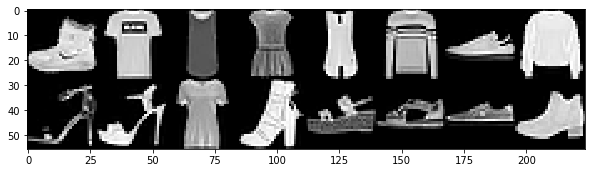

In [3]:
dataloader = iter(train_loader)
images, labels = dataloader.next()
# 데이터를 출력하기 위한 함수들

img = utils.make_grid(images, padding=0)
print("before make_grid:", images.shape)
print("after make_grid: ", img.shape)

npimg = img.numpy()
print(npimg.shape)

print(np.transpose(npimg, (1,2,0)).shape)
plt.figure(figsize=(10, 7))

# imshow 에 출력하는게 배열의 첫번째 원소다 이런게 중요한게 아니라,
# 차원의 정보가 더 중요하구나
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [4]:
# 클래스 분류 하기
CLASSES = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 한 번 이미지와 매칭되는지 보기
_labels = labels.numpy()
_labels = list(map(lambda x: CLASSES[x], _labels))
print(_labels)

['Ankle boot', 'T-shirt', 'T-shirt', 'Dress', 'T-shirt', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal', 'T-shirt', 'Ankle boot', 'Sandal', 'Sandal', 'Sneaker', 'Ankle boot']


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.act1(x)
        x = F.dropout(x, training=self.training, p=0.2)
        x = self.fc2(x)
        x = self.act2(x)
        x = F.dropout(x, training=self.training, p=0.2)
        output = self.fc3(x)
        return output
        
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 30
BATCH_SIZE = 64

In [8]:
net = Net().to(DEVICE)
optimizer = optim.SGD(net.parameters(), lr=0.01)
net.train()

def train(model, optimizer):
    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터 또한 cuda or cpu로 보내야 계산이 된다.
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        loss = F.cross_entropy(model(data), target)
        loss.backward()
        optimizer.step()

        if batch_idx % 1000 == 0:
            print("total loss: ", loss.item())
                
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # reduction='sum', 미니 배치 오차의 전체 합을 구한다.
            # default값은 평균이다.
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

for epoch in range(EPOCHS):
    test_loss, test_accuracy = evaluate(net, test_loader)
    print("[{}], Test Loss: {}, Accuracy: {}%".format(epoch, test_loss, test_accuracy))
    
    train(net, optimizer)

Test Loss: 2.3082326446533203, Accuracy: 10.05%
total loss:  2.3119282722473145
total loss:  1.0486630201339722
total loss:  0.7152985334396362
total loss:  0.47247791290283203
Test Loss: 0.5665716028213501, Accuracy: 80.23%
total loss:  0.6470259428024292
total loss:  0.8585343360900879
total loss:  0.5116642713546753
total loss:  0.37552008032798767
Test Loss: 0.49204239704608915, Accuracy: 82.6%
total loss:  0.4856599271297455
total loss:  0.7885053157806396
total loss:  0.5215099453926086
total loss:  0.3237667977809906
Test Loss: 0.45729220534563064, Accuracy: 83.65%
total loss:  0.4295852482318878
total loss:  0.7632150650024414
total loss:  0.5334694385528564
total loss:  0.28310367465019226
Test Loss: 0.4292945181965828, Accuracy: 84.71%
total loss:  0.38902997970581055
total loss:  0.7614255547523499
total loss:  0.5370656847953796
total loss:  0.2528395652770996
Test Loss: 0.41029410355091095, Accuracy: 85.48%
total loss:  0.36817237734794617
total loss:  0.7706118822097778
t